## Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split

import folium # map rendering library

import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## Load Data, and filter venues outside of Toronto

In [2]:
housing_toronto = pd.read_csv('props.csv', index_col=None)
housing_toronto = housing_toronto.drop(columns = 'Unnamed: 0').reset_index(drop=True)

housing_toronto = housing_toronto[housing_toronto['lat'] <= 43.75]
housing_toronto = housing_toronto[housing_toronto['lat'] >= 43.58]
housing_toronto = housing_toronto[housing_toronto['lng'] >= -79.60]
housing_toronto = housing_toronto[housing_toronto['lng'] <= -79.15]
housing_toronto = housing_toronto[housing_toronto['Address'].str.contains('Toronto')]
housing_toronto = housing_toronto[housing_toronto['Price ($)'] > 200000]
housing_toronto = housing_toronto.groupby('AreaName').mean()
housing_toronto = housing_toronto.reset_index()


## Get Averages for each AreaName

In [3]:
areas_final = housing_toronto
areas_final = areas_final.reset_index(drop = True)
areas_final.head()

,AreaName,Price ($),lat,lng
0,Alderwood,1.059907e+06,43.602732,-79.544717
1,Armour Heights,3.270000e+06,43.746012,-79.428058
2,Bay Cloverhill,2.490000e+05,43.665531,-79.385147
3,Beach Hill,8.990000e+05,43.678930,-79.313476
4,Bedford Park,1.770333e+06,43.727431,-79.410515


## Groupby AreaName and Count

In [4]:
df = pd.read_csv('venues_cleaned.csv')
df.groupby(['AreaName','category']).count()

id  name  venuelat  venuelng
AreaName                category                                     
Alderwood               Beach             2     2         2         2
                        Breakfast Spot    2     2         2         2
                        Burger Joint      2     2         2         2
                        Burrito Place     2     2         2         2
                        Café              2     2         2         2
...                                      ..   ...       ...       ...
York Mills              Tennis Court      2     2         2         2
                        Thai Restaurant   2     2         2         2
York University Heights Gym               2     2         2         2
                        Park              4     4         4         4
                        Soccer Field      2     2         2         2

[5912 rows x 4 columns]

## One-hot Encoding - with dummies

In [5]:
toronto_onehot = pd.get_dummies(df[['category']], prefix="", prefix_sep="")
toronto_onehot['AreaName'] = df['AreaName']
fixed_columns = list(toronto_onehot.columns[-1:]) + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(21396, 405)


,AreaName,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,...,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Transportation Service,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Richview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Richview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Richview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Richview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Richview,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
toronto_grouped = toronto_onehot.groupby(['AreaName']).mean().reset_index()

print(toronto_grouped.shape)
toronto_grouped.head()

(169, 405)


,AreaName,Accessories Store,African Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Astrologer,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,...,Thrift / Vintage Store,Tibetan Restaurant,Tourist Information Center,Toy / Game Store,Track,Trail,Train Station,Transportation Service,Tree,Tunnel,Turkish Restaurant,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Vineyard,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Alderwood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.031579,0.0,0.063158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010526,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00
1,Armour Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.000000,0.000000,0.00
2,Bay Cloverhill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.020000,0.000000,0.04
3,Beach Hill,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.033333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.033333,0.00
4,Bedford Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.029412,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.014706,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.014706,0.014706,0.000000,0.00


## Get Top n Venues

In [7]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['AreaName']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['AreaName'] = toronto_grouped['AreaName']

for ind in np.arange(toronto_grouped.shape[0]):
    row_categories = toronto_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(169, 11)


,AreaName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alderwood,Park,Discount Store,Trail,Pharmacy,Convenience Store,Pizza Place,Playground,Food Truck,Toy / Game Store,Shopping Mall
1,Armour Heights,Recreation Center,Ski Chalet,Bath House,Pool,Wine Shop,Fish Market,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant
2,Bay Cloverhill,Coffee Shop,Sushi Restaurant,Burger Joint,Gay Bar,Yoga Studio,Restaurant,Gym,Pub,Portuguese Restaurant,Ramen Restaurant
3,Beach Hill,Indian Restaurant,Café,Grocery Store,Park,Snack Place,Shopping Plaza,Sandwich Place,Baseball Field,Bar,Gym
4,Bedford Park,Bakery,Coffee Shop,Sushi Restaurant,Italian Restaurant,Cosmetics Shop,Asian Restaurant,Bank,Pizza Place,Sandwich Place,Burger Joint
...,...,...,...,...,...,...,...,...,...,...,...
164,Woodbine Heights,Gastropub,Coffee Shop,Arts & Crafts Store,Spa,Music Store,Sushi Restaurant,Bar,Bakery,Beer Store,Thai Restaurant
165,Wynford-Concorde,Coffee Shop,Beer Store,Deli / Bodega,Japanese Restaurant,Supermarket,Restaurant,Café,Dim Sum Restaurant,Nightclub,Asian Restaurant
166,Yonge and Lawrence,Bakery,Sushi Restaurant,Coffee Shop,Italian Restaurant,Pharmacy,Burger Joint,Asian Restaurant,Ice Cream Shop,Pub,Grocery Store
167,York Mills,Coffee Shop,Restaurant,Sandwich Place,Golf Course,Bus Stop,Butcher,Park,Optical Shop,Thai Restaurant,Bank


## In this Section I determine the right k-value to use using the elbowing-method.

In [8]:
toronto_grouped_clustering = toronto_grouped.drop(["AreaName"], 1)
inertia_hold = []
for i in range (1,169):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(toronto_grouped_clustering)
    inertia = kmeans.inertia_
    inertia_hold.append(inertia)

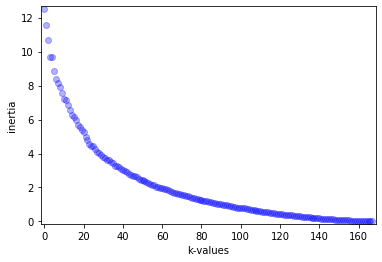

In [9]:
fig = plt.figure()
xs = range(len(inertia_hold))
ys = inertia_hold
plt.margins(x=0.01, y=0.01)
plt.scatter(xs, ys, c='b', alpha = 0.3)
plt.xlabel('k-values')
plt.ylabel('inertia')
plt.show()

## Hard to tell, but it seems to be 20 < k < 60 so let's replot it:

In [10]:
x = inertia_hold[20:60]

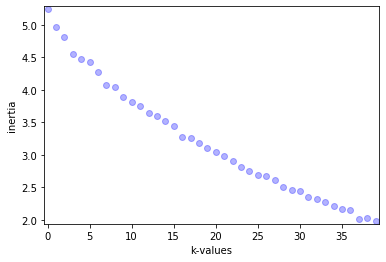

In [11]:
fig = plt.figure()
xs = range(len(x))
ys = x
plt.margins(x=0.01, y=0.01)
plt.scatter(xs, ys, c='b', alpha = 0.3)
plt.xlabel('k-values')
plt.ylabel('inertia')
plt.show()

## Assuming k=15 doesn't seem like a bad guess

In [12]:
kclusters = 15
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

In [13]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
toronto_merged = neighborhoods_venues_sorted.copy()

In [14]:
# add clustering labels
toronto_merged["Cluster Labels"] = kmeans.labels_

# merge toronto_merged with areas_final to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.merge(areas_final)

print(toronto_merged.shape)
toronto_merged.head() # check the last columns!

(169, 15)


,AreaName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Price ($),lat,lng
0,Alderwood,Park,Discount Store,Trail,Pharmacy,Convenience Store,Pizza Place,Playground,Food Truck,Toy / Game Store,Shopping Mall,1,1.059907e+06,43.602732,-79.544717
1,Armour Heights,Recreation Center,Ski Chalet,Bath House,Pool,Wine Shop,Fish Market,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,4,3.270000e+06,43.746012,-79.428058
2,Bay Cloverhill,Coffee Shop,Sushi Restaurant,Burger Joint,Gay Bar,Yoga Studio,Restaurant,Gym,Pub,Portuguese Restaurant,Ramen Restaurant,6,2.490000e+05,43.665531,-79.385147
3,Beach Hill,Indian Restaurant,Café,Grocery Store,Park,Snack Place,Shopping Plaza,Sandwich Place,Baseball Field,Bar,Gym,6,8.990000e+05,43.678930,-79.313476
4,Bedford Park,Bakery,Coffee Shop,Sushi Restaurant,Italian Restaurant,Cosmetics Shop,Asian Restaurant,Bank,Pizza Place,Sandwich Place,Burger Joint,9,1.770333e+06,43.727431,-79.410515


In [15]:
# sort the results by Cluster Labels
print(toronto_merged.shape)
toronto_merged.sort_values(["Cluster Labels"], inplace=True)
toronto_merged.head()

(169, 15)


,AreaName,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Price ($),lat,lng
10,Briar Hill,Grocery Store,Gym Pool,Convenience Store,Pub,Park,Yoga Studio,Event Space,Doner Restaurant,Donut Shop,Dumpling Restaurant,0,5.490000e+05,43.702183,-79.444046
130,South Cedarbrae,Flower Shop,Grocery Store,Playground,Yoga Studio,Falafel Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,0,5.990000e+05,43.745686,-79.236183
91,Mississauga,Park,Bakery,Gourmet Shop,Pizza Place,Vietnamese Restaurant,Grocery Store,Gas Station,Yoga Studio,Event Space,Donut Shop,0,3.641875e+05,43.616276,-79.595207
59,Guildwood,Grocery Store,Pizza Place,Sandwich Place,Park,Coffee Shop,Sports Bar,Bus Line,Field,Doner Restaurant,Donut Shop,0,1.257000e+06,43.741384,-79.202923
63,Humber Bay,Coffee Shop,Park,Farmers Market,Bank,Liquor Store,Pharmacy,Italian Restaurant,Grocery Store,Tennis Court,Sushi Restaurant,1,7.317423e+05,43.625974,-79.485690


## Get Lat/Lng for Folium Map

In [16]:
address = 'Toronto'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)

In [17]:
latitude = 43.6532
longitude = -79.3832
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6532, -79.3832.


In [18]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster, area in zip(toronto_merged['lat'], toronto_merged['lng'], toronto_merged['Cluster Labels'], toronto_merged['AreaName']):
    label = folium.Popup('Cluster {}, {}'.format(cluster, area), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [19]:
for i in range(kclusters):
    print('Cluster # {}'.format(i))
    print(toronto_merged.loc[toronto_merged['Cluster Labels'] == i, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]])

Cluster # 0
    1st Most Common Venue  5th Most Common Venue 6th Most Common Venue  \
10          Grocery Store                   Park           Yoga Studio   
130           Flower Shop     Falafel Restaurant            Donut Shop   
91                   Park  Vietnamese Restaurant         Grocery Store   
59          Grocery Store            Coffee Shop            Sports Bar   

    7th Most Common Venue        8th Most Common Venue 9th Most Common Venue  \
10            Event Space             Doner Restaurant            Donut Shop   
130   Dumpling Restaurant  Eastern European Restaurant   Egyptian Restaurant   
91            Gas Station                  Yoga Studio           Event Space   
59               Bus Line                        Field      Doner Restaurant   

    10th Most Common Venue  Cluster Labels  Price ($)        lat        lng  
10     Dumpling Restaurant               0   549000.0  43.702183 -79.444046  
130      Electronics Store               0   599000.0  43.74

## Modelling

In [20]:
toronto_grouped['price'] = areas_final['Price ($)']

In [21]:
toronto_grouped.shape

(169, 406)

In [22]:
data = toronto_grouped.drop(columns = 'AreaName')
feature_cols = data.columns
X = data.loc[:, feature_cols]
y = data.iloc[:,-1]
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Columns: 405 entries, Accessories Store to price
dtypes: float64(405)
memory usage: 534.9 KB


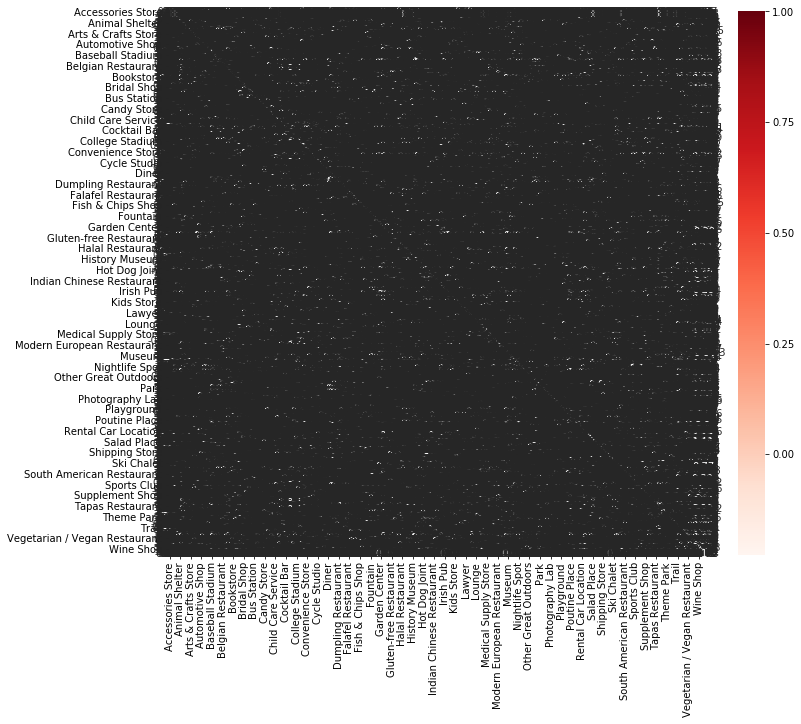

In [23]:
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [36]:
cor_target = abs(cor["price"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
x = relevant_features.T
x = x.reset_index()
relevant_features = list(x['index'])


In [63]:
toronto_new = toronto_grouped[relevant_features]
toronto_new.head()

,Bath House,Beer Store,Botanical Garden,Butcher,Chinese Restaurant,Convenience Store,Dentist's Office,Discount Store,Frozen Yogurt Shop,Furniture / Home Store,Garden,General Entertainment,Grocery Store,Jewelry Store,Lighting Store,Music Venue,Non-Profit,Park,Pool,Post Office,Recording Studio,Recreation Center,Ski Chalet,Snack Place,Spa,Vietnamese Restaurant,Wine Shop,price
0,0.00,0.000000,0.0,0.0,0.00,0.042105,0.0,0.063158,0.000000,0.0,0.0,0.00,0.021053,0.0,0.0,0.0,0.000000,0.105263,0.021053,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.000000,1.059907e+06
1,0.25,0.000000,0.0,0.0,0.00,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.125000,0.0,0.0,0.25,0.25,0.000000,0.0,0.0,0.125000,3.270000e+06
2,0.00,0.000000,0.0,0.0,0.02,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.02,0.000000,0.0,0.0,0.0,0.000000,0.020000,0.000000,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.000000,2.490000e+05
3,0.00,0.000000,0.0,0.0,0.00,0.000000,0.0,0.033333,0.000000,0.0,0.0,0.00,0.100000,0.0,0.0,0.0,0.000000,0.033333,0.000000,0.0,0.0,0.00,0.00,0.033333,0.0,0.0,0.000000,8.990000e+05
4,0.00,0.014706,0.0,0.0,0.00,0.000000,0.0,0.000000,0.014706,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.014706,0.000000,0.014706,0.0,0.0,0.00,0.00,0.000000,0.0,0.0,0.014706,1.770333e+06


In [64]:
toronto_new['lat'] = areas_final['lat']
toronto_new['lng'] = areas_final['lng']

C:\Users\Faizan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Faizan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [65]:
inertia_hold = []
for i in range (1,28):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(toronto_new)
    inertia = kmeans.inertia_
    inertia_hold.append(inertia)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


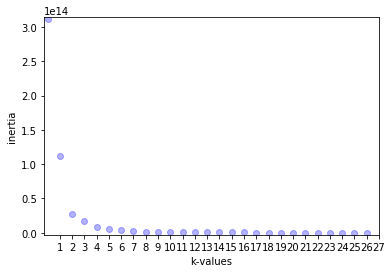

In [66]:
fig = plt.figure()
xs = range(len(inertia_hold))
ys = inertia_hold
plt.margins(x=0.01, y=0.01)
plt.scatter(xs, ys, c='b', alpha = 0.3)
plt.xticks(ticks=list(range(1,28)))
plt.xlabel('k-values')
plt.ylabel('inertia')
plt.show()

In [67]:
kclusters = 4
toronto_new["Cluster Labels"] = kmeans.labels_
toronto_new["AreaName"] = toronto_grouped['AreaName']

C:\Users\Faizan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Faizan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [68]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster, area in zip(toronto_new['lat'], toronto_new['lng'], toronto_new['Cluster Labels'], toronto_new['AreaName']):
    label = folium.Popup('Cluster {}, {}'.format(cluster, area), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

IndexError: list index out of range

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [29]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X_train,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #

ValueError: Unknown label type: (array([ 829000.        ,  483952.23      ,  726780.        ,
        634892.85714286,  668400.        , 1621300.        ,
       1035046.15384615,  539900.        ,  309400.        ,
        825450.        ,  506175.        , 1770333.33333333,
       1049950.        ,  594000.        ,  750969.9       ,
        416500.        ,  829199.29411765,  549000.        ,
        624000.        , 1597250.        , 1059907.07142857,
        811694.95      ,  765191.14285714,  521294.11111111,
        476175.        ,  643659.6       ,  567175.        ,
       2785000.        , 1079220.        ,  885328.57142857,
       2749900.        ,  903250.        ,  445600.        ,
       2261576.81818182, 1105865.88888889,  690394.0952381 ,
       1145666.66666667,  976288.88888889, 1282666.66666667,
       1124500.        ,  279900.        ,  841499.9       ,
        613452.85714286,  586584.        ,  551425.        ,
        814594.23809524,  825432.28571429,  981961.        ,
       3498950.        , 1080046.15384615, 4768648.        ,
       2290250.        ,  699900.        ,  902950.        ,
        699000.        ,  757633.33333333,  899000.        ,
        574333.33333333,  504584.85714286, 1065199.6       ,
       1009677.31818182,  382012.57142857,  523233.33333333,
        531414.28571429,  716040.        , 3627822.22222222,
        536704.5       ,  888038.0952381 ,  306633.33333333,
        364187.5       ,  478431.25      ,  699674.35      ,
       1002738.46153846, 1523448.42007435, 1002152.63157895,
        569452.75      , 2195966.66666667,  949000.        ,
       1257000.        ,  817380.80952381,  599000.        ,
        574876.19047619, 2537500.        , 1506322.22222222,
        682333.33333333, 2717857.14285714,  731742.30769231,
        280940.        , 2795000.        ,  436963.63636364,
       1589000.        ,  649000.        ,  539352.94117647,
        662499.5       ,  904200.        ,  512450.        ,
        916087.5       ,  384900.        ,  632441.80312907,
       4737110.        , 3270000.        ,  549963.33333333,
       1269360.46153846,  599000.        ,  574660.        ,
        643602.04166667, 2095135.        ,  607302.97014925,
        824933.33333333,  541607.33333333, 2144700.        ,
        951000.        ,  629500.        ,  709000.        ,
        898000.        , 1198116.66666667,  478420.33333333,
       1104000.        ]),)